Figure 3 do publikacji według opisu:

Full tumour growth time profiles in training set were clustered using unsupervised learning. Plots A, B, C, D show four example clusters exhibiting different behaviours and surrogate model trajectory inferred by machine learning. Plots E, F show comparison of tumour growth trajectories simulated by original and surrogate model for two parameter sets from testing dataset.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import pickle

DATASET_PREFIX = 50_000

input_and_output = np.load("../final/dataset.npz")
inputs  = input_and_output["inputs"].astype(np.float64)[:DATASET_PREFIX, :]
outputs = input_and_output["outputs"].astype(np.float64)[:DATASET_PREFIX, :]


LOGNORMAL_PARAMETERS = (1, 2)
class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res


from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from threadpoolctl import threadpool_limits
from cpuinfo import get_cpu_info
from sklearn.decomposition import PCA


with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)

with Path(f"../final/pca/11_-7.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

with Path("../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle").open("rb") as opened_file:
    regressor = pickle.load(opened_file)
    
def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

def predict(*args):
    with threadpool_limits(limits=get_cpu_info()["count"], user_api='blas'):
        return regressor.predict(*args)

def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs <= -7
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

simulator = make_pipeline(
    FunctionTransformer(drop_treatment),
    scaler,
    FunctionTransformer(predict),
    FunctionTransformer(pca.inverse_transform),
    FunctionTransformer(output_untransform)
)

AttributeError: 'FunctionTransformer' object has no attribute 'predict'

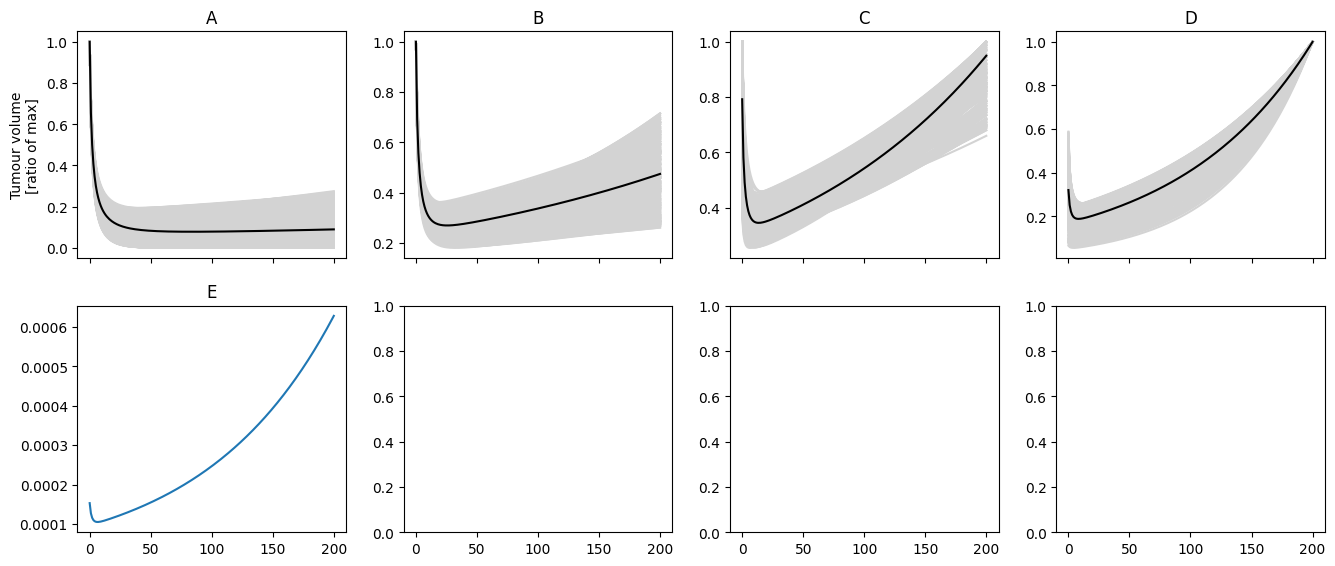

In [20]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=10, init='random', max_iter=300, random_state=42)

normalized_outputs = outputs / outputs.max(axis=1, initial=0)[:, None]
kmeans.fit(normalized_outputs)
cluster_labels = kmeans.labels_

rows = 2
cols = n_clusters
figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.3, rows * 3.5)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

x_axis = np.linspace(0, 200, normalized_outputs.shape[1])

example_count = 500

for iteration, i in enumerate([3, 1, 0, 2]):
    row = iteration // cols
    col = iteration - row * cols
    letter = chr(ord('A') + iteration)
    
    cluster = normalized_outputs[cluster_labels == i, :]
    centroid = kmeans.cluster_centers_[i]
    # idx = np.argmin(np.square(cluster - centroid).sum(axis=1))
    axs[row, col].set_title(letter)

    for c_i in range(example_count):
        axs[row, col].plot(x_axis, cluster[c_i, :], color='lightgray')
    
    axs[row, col].plot(x_axis, centroid, color='black')
    
axs[0, 0].set_ylabel("Tumour volume\n[ratio of max]")

example_id = 4
for iteration, i in enumerate([2, 1, 0, 3]):
    axs[1, iteration].plot(x_axis, outputs[cluster_labels == i, :][example_id, :])
    axs[1, iteration].set_title(chr(ord('E') + iteration))
    parameters = inputs[cluster_labels == i, :][example_id:(example_id+1), :]
    model_output = simulator.transform(parameters)
    # model_output_normalized = model_output / model_output.max(axis=1, initial=0)[:, None]
    axs[1, iteration].plot(x_axis, model_output[0, :], linestyle='dashed')

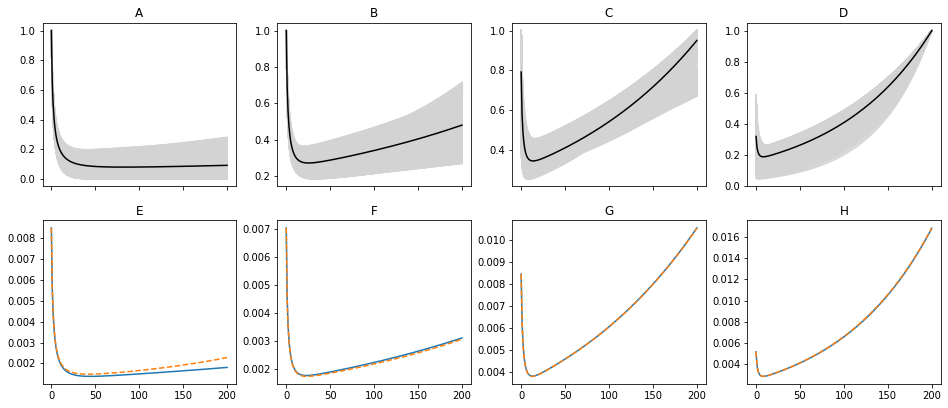

In [32]:
from lazarou_model.clustering.by_curve import ByCurve
from lazarou_model.clustering.compare_cluster_sizes import CompareClusterSizes, CurveNormalization
from lazarou_model.datasets.dataset import Dataset


n_clusters = 4
DATASET = Dataset.load_npz("sample_treated_test_500k_1.npz").prefix(50_000)
OUTPUT_DIR = Path("../data/clustering")
compare_clusters = CompareClusterSizes(
    DATASET,
    [n_clusters],
    CurveNormalization.max,
    OUTPUT_DIR
)

model = ByCurve(n_clusters)
raw_dataset = compare_clusters.normalized_train_set()
model.fit_or_load(raw_dataset, compare_clusters.normalized_train_set_name(), OUTPUT_DIR)
cluster_labels = model.predict(raw_dataset)

rows = 2
cols = 4
figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.3, rows * 3.5)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

x_axis = np.linspace(0, 200, raw_dataset.shape[1])

example_count = 1000

for iteration, i in enumerate([2, 1, 0, 3]):
    row = iteration // cols
    col = iteration - row * cols
    letter = chr(ord('A') + iteration)
    
    cluster = raw_dataset[cluster_labels == i, :]
    centroid = model.cluster_centers()[i]
    # idx = np.argmin(np.square(cluster - centroid).sum(axis=1))
    axs[row, col].set_title(letter)

    for c_i in range(example_count):
        axs[row, col].plot(x_axis, cluster[c_i, :], color='lightgray')
    
    axs[row, col].plot(x_axis, centroid, color='black')

example_id = 4
for iteration, i in enumerate([2, 1, 0, 3]):
    axs[1, iteration].plot(x_axis, DATASET.outputs()[cluster_labels == i, :][example_id, :])
    axs[1, iteration].set_title(chr(ord('E') + iteration))
    parameters = DATASET.inputs()[cluster_labels == i, :][example_id:(example_id+1), :]
    model_output = simulator.model_predict(parameters)
    # model_output_normalized = model_output / model_output.max(axis=1, initial=0)[:, None]
    axs[1, iteration].plot(x_axis, model_output[0, :], linestyle='dashed')
